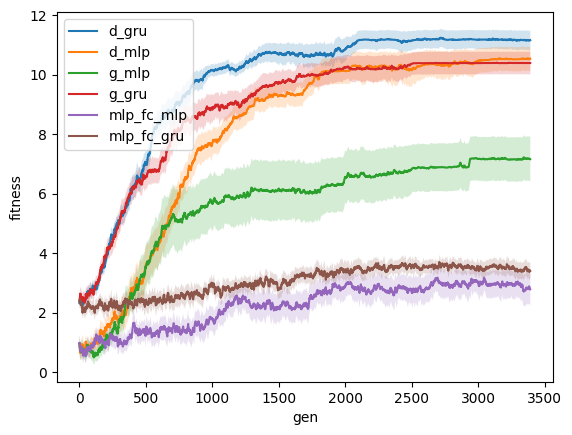

In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import csv
import numpy as np
import os
import yaml

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plotting_dir = Path().resolve()
config_dir = plotting_dir / "config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

batch_name = config["batch_name"]
experiment_names = config["experiment_names"]

stat_run_base_path = plotting_dir.parent / "experiments" / "results"

stat_run_paths = [stat_run_base_path / batch_name / experiment for experiment in experiment_names]

trials_start = config["trials_start"]
trials_finish = config["trials_finish"]
data_points = config["data_points"]
moving_avg_window_size = config["moving_avg_window_size"]

trials = trials_finish-trials_start

dd_list = []

for i in range(len(stat_run_paths)):

    for trial in range(trials_start,trials_finish):

        dd = defaultdict(list)

        with open(
            os.path.join(stat_run_paths[i], "_".join(("trial", str(trial))), "fitness.csv"), "r"
        ) as csvfile:
            for line in csv.DictReader(csvfile):
                for key, value in line.items():
                    if key != "" and value != "" and value != None and not isinstance(value, list):
                        dd[key].append(float(value))

        dd_list.append(dd)

best_team_fitness_avg_vals = []
best_team_fitness_std_vals = []

avg_team_fitness_avg_vals = []
avg_team_fitness_std_vals = []

for i in range(len(experiment_names)):

    best_team_fitness = []
    avg_team_fitness = []

    for dd in dd_list[i * trials : (i + 1) * trials]:
        best_team_fitness.append(np.array(dd["best_team_fitness"][:data_points]))
        avg_team_fitness.append(np.array(dd["avg_team_fitness"][:data_points]))

    best_team_fitness = np.array(best_team_fitness)
    avg_team_fitness = np.array(avg_team_fitness)

    best_team_fitness_avg_vals.append(np.mean(best_team_fitness, axis=0))
    best_team_fitness_std_vals.append(np.std(best_team_fitness, axis=0))

    avg_team_fitness_avg_vals.append(np.mean(avg_team_fitness, axis=0))
    avg_team_fitness_std_vals.append(np.std(avg_team_fitness, axis=0))


fig = plt.figure()
ax = fig.add_subplot(111)

for best_fitness_avg, avg_fitness_avg, std_vals in zip(best_team_fitness_avg_vals,avg_team_fitness_avg_vals, best_team_fitness_std_vals):

    best_fitness_moving_avg = moving_average(best_fitness_avg, moving_avg_window_size)
    avg_fitness_moving_avg = moving_average(avg_fitness_avg, moving_avg_window_size)
    moving_std = moving_average(std_vals, moving_avg_window_size)

    std_plus = best_fitness_moving_avg + moving_std/np.sqrt(trials)
    std_minus = best_fitness_moving_avg - moving_std/np.sqrt(trials)

    ax.plot(best_fitness_moving_avg)
    # ax.plot(avg_fitness_moving_avg)
    # ax.plot(moving_std)
    ax.fill_between(np.linspace(0, best_fitness_moving_avg.shape[0], best_fitness_moving_avg.shape[0]), std_plus, std_minus, alpha=0.2, label="_nolegend_")

ax.set_xlabel("gen")
ax.set_ylabel("fitness")

plt.legend(experiment_names) 

plt.show()
